Training the model with the best hyperparameters...
Epoch 1/50
704/704 [==============================] - 188s 265ms/step - loss: 1.5067 - accuracy: 0.4725 - val_loss: 1.4093 - val_accuracy: 0.5048
Epoch 2/50
704/704 [==============================] - 185s 262ms/step - loss: 1.0410 - accuracy: 0.6319 - val_loss: 1.6051 - val_accuracy: 0.4980
Epoch 3/50
704/704 [==============================] - 187s 265ms/step - loss: 0.8745 - accuracy: 0.6935 - val_loss: 0.9677 - val_accuracy: 0.6480
Epoch 4/50
704/704 [==============================] - 188s 267ms/step - loss: 0.7960 - accuracy: 0.7221 - val_loss: 0.7647 - val_accuracy: 0.7314
Epoch 5/50
704/704 [==============================] - 187s 266ms/step - loss: 0.7286 - accuracy: 0.7442 - val_loss: 0.7255 - val_accuracy: 0.7512
Epoch 6/50
704/704 [==============================] - 188s 267ms/step - loss: 0.6875 - accuracy: 0.7592 - val_loss: 0.7803 - val_accuracy: 0.7338
Epoch 7/50
704/704 [==============================] - 189s 269ms/step - 

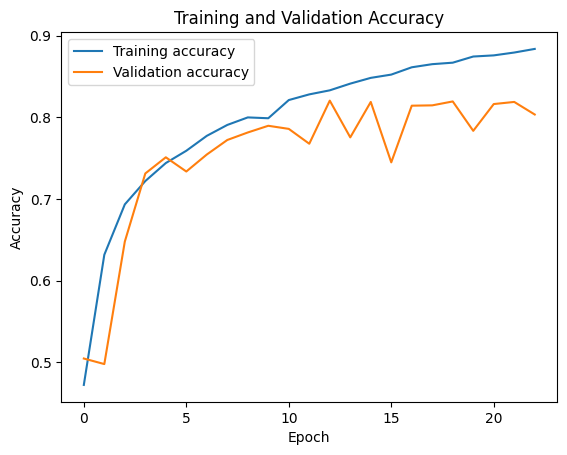

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import time

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = tf.keras.utils.to_categorical(y_train), tf.keras.utils.to_categorical(y_test)

validation_split = 0.1
split_index = int(len(x_train) * validation_split)
x_val, y_val = x_train[:split_index], y_train[:split_index]
x_train, y_train = x_train[split_index:], y_train[split_index:]

sample_size = 5000  # Adjust this value as needed
sample_indices = np.random.choice(np.arange(x_train.shape[0]), sample_size, replace=False)

x_train_small = x_train[sample_indices]
y_train_small = y_train[sample_indices]

# Define the fitness function
def fitness_function(num_filters1, num_filters2, dense_units, learning_rate):
    num_filters1 = max(1, round(num_filters1))
    num_filters2 = max(1, round(num_filters2))
    dense_units = max(1, round(dense_units))
    print(f"num_filters1: {num_filters1}, num_filters2: {num_filters2}")
    model = Sequential([
        Conv2D(num_filters1, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(num_filters1, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(num_filters2, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(num_filters2, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(dense_units, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(x_train_small, y_train_small, epochs=10, batch_size=256,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping],
                        verbose=0)

    return history.history['val_loss'][-1]

# Define the ACO class
class ACO:
    def __init__(self, fitness_function, colony_size, n_iterations, num_params, lower_bounds, upper_bounds, alpha, beta, rho, q, seed=None, num_discrete_values=10, randomness_factor=0.1):
        self.fitness_function = fitness_function
        self.colony_size = colony_size
        self.n_iterations = n_iterations
        self.num_params = num_params
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.seed = seed
        self.num_discrete_values = num_discrete_values
        self.randomness_factor = randomness_factor
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        # Create the discretized search space for each parameter
        self.discrete_values = [np.linspace(lower_bounds[i], upper_bounds[i], num=self.num_discrete_values) for i in range(self.num_params)]

        # Initialize the pheromone matrix
        self.pheromone_matrix = np.ones((self.num_params, self.num_discrete_values))

    def run(self):
        best_solution = None
        best_fitness = float('inf')

        for iteration in range(self.n_iterations):
            solutions = []
            fitnesses = []
            discrete_solution_indices_list = []

            for ant_index in range(self.colony_size):
                solution = []
                discrete_solution_indices = []

                for i in range(self.num_params):
                    probabilities = self.pheromone_matrix[i] ** self.alpha * (1 / self.discrete_values[i]) ** self.beta
                    probabilities /= np.sum(probabilities)
                    
                    # Add randomness
                    if random.random() < self.randomness_factor:
                        discrete_index = random.randint(0, self.num_discrete_values - 1)
                    else:
                        discrete_index = np.random.choice(np.arange(self.num_discrete_values), p=probabilities)

                    solution.append(self.discrete_values[i][discrete_index])
                    discrete_solution_indices.append(discrete_index)

                # Print progress before evaluating the fitness
                print(f'Iteration {iteration + 1}, Ant {ant_index + 1}: Evaluating...')
                fitness = self.fitness_function(*solution)

                solutions.append(solution)
                fitnesses.append(fitness)
                discrete_solution_indices_list.append(discrete_solution_indices)

                if fitness < best_fitness:
                    best_fitness = fitness
                    best_solution = solution

                # Print progress of each ant
                print(f'Iteration {iteration + 1}, Ant {ant_index + 1}: Current solution: {solution}, Current validation loss: {fitness}')

            # Update pheromone levels after all ants have completed their search in the current iteration
            for ant_index in range(self.colony_size):
                fitness = fitnesses[ant_index]
                discrete_solution_indices = discrete_solution_indices_list[ant_index]
                for i in range(self.num_params):
                    self.pheromone_matrix[i] *= (1 - self.rho)
                    self.pheromone_matrix[i, discrete_solution_indices[i]] += self.q / fitness

            print(f'Iteration {iteration + 1}: Best solution: {best_solution}, Best validation loss: {best_fitness}')

        return best_solution, best_fitness



# Set the ACO hyperparameters and bounds for the CNN hyperparameters
colony_size = 20
n_iterations = 20
num_params = 4
lower_bounds = [16, 16, 256, 0.0001]
upper_bounds = [128, 128, 1024, 0.01]
alpha = 1.5
beta = 4
rho = 0.8
q = 0.3
randomness_factor = 0.5

# # Create and run the ACO optimizer
# print("Starting the ACO optimizer...")
# aco = ACO(fitness_function, colony_size, n_iterations, num_params, lower_bounds, upper_bounds, alpha, beta, rho, q, seed=42,randomness_factor=randomness_factor)
# best_hyperparameters, best_val_loss = aco.run()

# best_num_filters1, best_num_filters2, best_dense_units, best_learning_rate = best_hyperparameters
# best_num_filters1, best_num_filters2, best_dense_units = int(best_num_filters1), int(best_num_filters2), int(best_dense_units)

# print(f"Best hyperparameters found by ACO: num_filters1={best_num_filters1}, "
#       f"num_filters2={best_num_filters2}, dense_units={best_dense_units}, "
#       f"learning_rate={best_learning_rate}")

best_num_filters1=90
best_num_filters2=53
best_dense_units=256
best_learning_rate=0.0078000000000000005
# Train the model with the best hyperparameters found by ACO
print("Training the model with the best hyperparameters...")

# Train the model with the best hyperparameters found by ACO
best_model = Sequential([
    Conv2D(best_num_filters1, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(best_num_filters1, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(best_num_filters2, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(best_num_filters2, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(best_dense_units, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

best_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time = time.time()
history = best_model.fit(x_train, y_train, epochs=50, batch_size=64,
                         validation_data=(x_val, y_val),
                         callbacks=[early_stopping],
                         verbose=1)
end_time = time.time()

training_time = end_time - start_time
print(f'Total training time: {training_time:.2f} seconds')

# Evaluate the best model on the test dataset
print("Evaluating the model on the test dataset...")
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f'Test accuracy: {test_acc}')

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

# Calculate ROC-AUC for multi-class classification
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc}')

# Plot the training and validation accuracies
print("Plotting the training and validation accuracies...")
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()






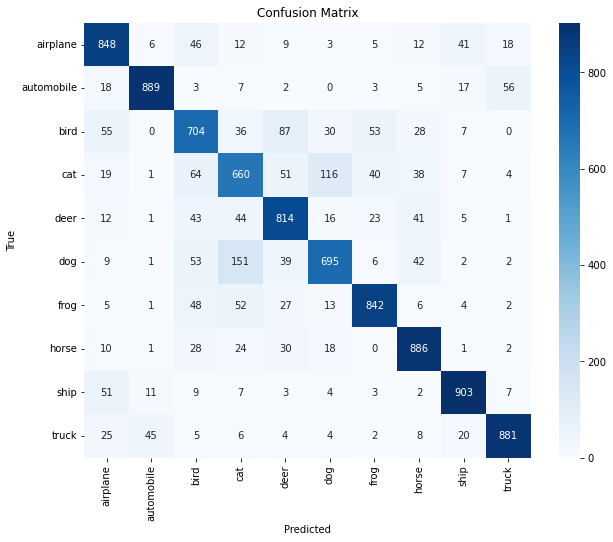

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix data
confusion_matrix = np.array([
    [848, 6, 46, 12, 9, 3, 5, 12, 41, 18],
    [18, 889, 3, 7, 2, 0, 3, 5, 17, 56],
    [55, 0, 704, 36, 87, 30, 53, 28, 7, 0],
    [19, 1, 64, 660, 51, 116, 40, 38, 7, 4],
    [12, 1, 43, 44, 814, 16, 23, 41, 5, 1],
    [9, 1, 53, 151, 39, 695, 6, 42, 2, 2],
    [5, 1, 48, 52, 27, 13, 842, 6, 4, 2],
    [10, 1, 28, 24, 30, 18, 0, 886, 1, 2],
    [51, 11, 9, 7, 3, 4, 3, 2, 903, 7],
    [25, 45, 5, 6, 4, 4, 2, 8, 20, 881]
])

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()